In [1]:
from tensorflow.keras import models, layers, utils
import matplotlib.pyplot as pyplot
import tensorflow as tf

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

/home/tomasz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tomasz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tomasz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tomasz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() 


In [3]:
from sklearn.preprocessing import label_binarize

y_bin_train = label_binarize(y_train, classes=[*range(10)])
y_bin_test = label_binarize(y_test, classes=[*range(10)])

In [4]:
y_bin_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [5]:
model = models.Sequential()

# Pierwsza warstwa konwolucyjna
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# Druga warstwa konwolucyjna
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# trzecia warstwa konwolucyjna
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))


# czwarta warstwa konwolucyjna
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# Zamiana trójwymiarowej macierzy na jednowymiarowy wektor (przestawienie kolejnych wierszy kolumn liniowo)
model.add(layers.Flatten())

# Sieć neuronowa
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
____

In [7]:
#TEST !!!
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
____

In [9]:
#TEST !!!
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
x_train[0].shape

(32, 32, 3)

In [7]:

model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:



x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255




In [ ]:
import numpy as np

def zamien(y_pred):
    res = np.empty((y_pred.shape[0], 10))
    for pred in range(len(y_pred)):
        pres = np.empty(10)
        for i in range(10):
            if i == y_pred[pred]:
                pres[i] = 1
            else:
                pres[i] = 0
        res[pred] = pres
    return res

def zmaksuj(y_pred):
    res = np.array(y_pred, copy=True)
    for pred in range(len(y_pred)):
        argmax = y_pred[pred].argmax()
        for i in range(10):
            if i == argmax:
                res[pred][i] = 1
            else:
                res[pred][i] = 0
    return res
                
        

In [9]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 98s 2ms/sample - loss: 2.2768 - acc: 0.1260 - val_loss: 2.2261 - val_acc: 0.2042
Epoch 2/10
50000/50000 [==============================] - 92s 2ms/sample - loss: 2.1174 - acc: 0.2015 - val_loss: 2.0520 - val_acc: 0.2369
Epoch 3/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 2.0362 - acc: 0.2354 - val_loss: 2.1278 - val_acc: 0.2065
Epoch 4/10
50000/50000 [==============================] - 97s 2ms/sample - loss: 1.9544 - acc: 0.2698 - val_loss: 1.9496 - val_acc: 0.2972
Epoch 5/10
50000/50000 [==============================] - 103s 2ms/sample - loss: 1.8746 - acc: 0.2962 - val_loss: 1.7737 - val_acc: 0.3541
Epoch 6/10
50000/50000 [==============================] - 119s 2ms/sample - loss: 1.7974 - acc: 0.3302 - val_loss: 1.7056 - val_acc: 0.3817
Epoch 7/10
50000/50000 [==============================] - 156s 3ms/sample - loss: 1.7310 - acc: 0.3619 - val_loss:

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.5010654041290283
Test accuracy: 0.4566


In [35]:
from sklearn.metrics import log_loss

y_zmodelu = model.predict(x_test)
log_loss(y_test, y_zmodelu)

4.038689547200501

array([[2.37889158e-02, 1.46007613e-02, 1.31677842e-01, ...,
        4.70285293e-02, 1.15706764e-02, 3.86237877e-02],
       [8.40601035e-02, 6.03852302e-01, 9.71220267e-04, ...,
        2.47050504e-04, 2.44410466e-01, 6.55844384e-02],
       [6.78701404e-02, 6.98859334e-01, 2.13034387e-03, ...,
        1.70106619e-03, 1.04588525e-01, 1.20351885e-01],
       ...,
       [6.28645318e-04, 1.60141854e-04, 2.86529278e-02, ...,
        1.78825169e-01, 3.74211153e-04, 1.38603350e-03],
       [3.68728181e-01, 4.80125931e-01, 1.08121964e-02, ...,
        9.48315566e-03, 1.90461828e-02, 6.13002895e-02],
       [4.40202777e-03, 4.69468660e-03, 7.09033414e-02, ...,
        6.33877340e-01, 9.22996329e-04, 8.44490073e-03]])

In [15]:
layer_name = "flatten"
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)


intermediate_output = intermediate_layer_model.predict(x_train)

In [16]:
intermediate_output.shape

(50000, 128)

In [17]:
from sklearn import svm

clf = svm.SVC(kernel='linear', probability=True)

clf.fit(intermediate_output, y_train)

/home/tomasz/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [34]:
from sklearn.metrics import accuracy_score

#y_pred = clf.predict_proba(intermediate_layer_model.predict(x_test))

accuracy_score(zamien(y_test), zmaksuj(y_pred))

0.5012

In [36]:
from sklearn.metrics import log_loss

log_loss(y_test, y_pred)

1.3803455788151744

In [41]:
#y_bin_pred = label_binarize(y_pred,  classes=[*range(10)])
#y_bin_pred

In [42]:
#y_bin_test

Text(0.5, 1.0, 'SVM P-R')

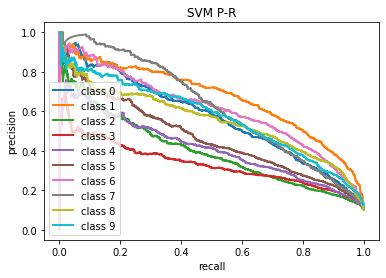

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve
for i in range(10):
    p, r, _ = precision_recall_curve(y_bin_test[:, i], y_pred[:, i])
    plt.plot(r, p, lw=2, label='class {}'.format(i))
    
plt.legend(loc="best")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("SVM P-R")

Text(0.5, 1.0, 'SVM ROC')

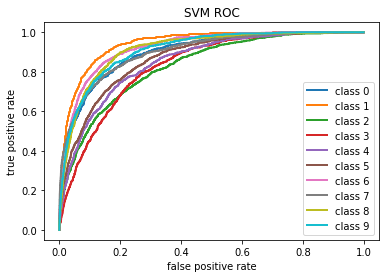

In [38]:
for i in range(10):
    fpr, tpr, _ = roc_curve(y_bin_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, lw=2, label='class {}'.format(i))
    
plt.legend(loc="best")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("SVM ROC")

Text(0.5, 1.0, 'CNN P-R')

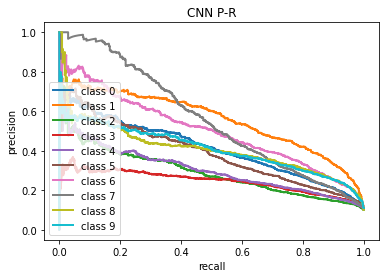

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve
for i in range(10):
    p, r, _ = precision_recall_curve(y_bin_test[:, i], y_zmodelu[:, i])
    plt.plot(r, p, lw=2, label='class {}'.format(i))
    
plt.legend(loc="best")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("CNN P-R")

Text(0.5, 1.0, 'CNN ROC')

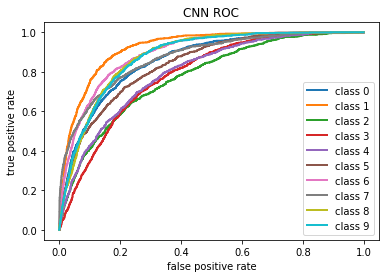

In [40]:
for i in range(10):
    fpr, tpr, _ = roc_curve(y_bin_test[:, i], y_zmodelu[:, i])
    plt.plot(fpr, tpr, lw=2, label='class {}'.format(i))
    
plt.legend(loc="best")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("CNN ROC")

In [13]:
#Potezne badania
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
from sklearn.metrics import log_loss
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np

# czyli po 10, po 40, po 80 i po 120
epoki = [10, 30, 40, 40]
epoki_h = [10, 40, 80, 120]

#TEST !!!
epoki = [10, 30, 30, 30]
epoki_h = [10, 40, 70, 100]
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

for IT in range(len(epoki)):
    #trening CNN
    history = model.fit(x_train, y_train_cat, epochs=epoki[IT], batch_size=64, validation_data=(x_test, y_test_cat))
    
    #model wyciagajacy wektory przed MLP
    layer_name = "flatten"
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

    #wektory przed MLP
    intermediate_output = intermediate_layer_model.predict(x_train)
    
    #trening SVM
    clf = svm.SVC(probability=True)
    clf.fit(intermediate_output, y_train)
    
    print("Wyniki po "+str(epoki_h[IT]))
    
    #ocena CNN
    print("Dla CNN")
    score = model.evaluate(x_test, y_test_cat, verbose=0)
    #print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    y_zmodelu = model.predict(x_test)
    print("Loss: ")
    print(log_loss(y_test, y_zmodelu))
    print("f1-score: ")
    print(f1_score(zamien(y_test), zmaksuj(y_zmodelu), average='macro'))
    
    plt.figure()
    aucs = dict()
    for i in range(10):
        p, r, _ = precision_recall_curve(y_bin_test[:, i], y_zmodelu[:, i])
        plt_auc = auc(r, p)
        aucs[i] = plt_auc
        plt.plot(r, p, lw=2, label='class {0} ({1:0.2f})'.format(i, plt_auc))
    
    plt.legend(loc="best")
    plt.xlabel("recall")
    plt.ylabel("precision")
    avg_auc = np.average(np.array(list(aucs.items()))[:,1])
    plt.title("CNN P-R ({0:0.2f})".format(avg_auc))
    
    plt.figure()
    aucs = dict()
    for i in range(10):
        fpr, tpr, _ = roc_curve(y_bin_test[:, i], y_zmodelu[:, i])
        plt_auc = auc(fpr, tpr)
        aucs[i] = plt_auc
        plt.plot(fpr, tpr, lw=2, label='class {0} ({1:0.2f})'.format(i, plt_auc))

    plt.legend(loc="best")
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    avg_auc = np.average(np.array(list(aucs.items()))[:,1])
    plt.title("CNN ROC ({0:0.2f})".format(avg_auc))
    
    #ocena SVM
    print("Dla SVM")
    y_pred = clf.predict_proba(intermediate_layer_model.predict(x_test))
    print("Accuracy: ")
    print(accuracy_score(zamien(y_test), zmaksuj(y_pred)))
    print("Loss: ")
    print(log_loss(y_test, y_pred))
    print("f1-score: ")
    print(f1_score(zamien(y_test), zmaksuj(y_pred), average='macro'))
    
    plt.figure()
    aucs = dict()
    for i in range(10):
        p, r, _ = precision_recall_curve(y_bin_test[:, i], y_pred[:, i])
        plt_auc = auc(r, p)
        aucs[i] = plt_auc
        plt.plot(r, p, lw=2, label='class {0} ({1:0.2f})'.format(i, plt_auc))

    plt.legend(loc="best")
    plt.xlabel("recall")
    plt.ylabel("precision")
    avg_auc = np.average(np.array(list(aucs.items()))[:,1])
    plt.title("SVM P-R ({0:0.2f})".format(avg_auc))
    
    plt.figure()
    aucs = dict()
    for i in range(10):
        fpr, tpr, _ = roc_curve(y_bin_test[:, i], y_pred[:, i])
        plt_auc = auc(fpr, tpr)
        aucs[i] = plt_auc
        plt.plot(fpr, tpr, lw=2, label='class {0} ({1:0.2f})'.format(i, plt_auc))

    plt.legend(loc="best")
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    avg_auc = np.average(np.array(list(aucs.items()))[:,1])
    plt.title("SVM ROC ({0:0.2f})".format(avg_auc))
    

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 190s 4ms/sample - loss: 2.0025 - acc: 0.2529 - val_loss: 1.6934 - val_acc: 0.3777
Epoch 2/10
50000/50000 [==============================] - 196s 4ms/sample - loss: 1.6629 - acc: 0.3844 - val_loss: 1.5166 - val_acc: 0.4549
Epoch 3/10
50000/50000 [==============================] - 199s 4ms/sample - loss: 1.5162 - acc: 0.4446 - val_loss: 1.4056 - val_acc: 0.4857
Epoch 4/10
50000/50000 [==============================] - 201s 4ms/sample - loss: 1.4143 - acc: 0.4846 - val_loss: 1.3104 - val_acc: 0.5252
Epoch 5/10
50000/50000 [==============================] - 237s 5ms/sample - loss: 1.3375 - acc: 0.5115 - val_loss: 1.2412 - val_acc: 0.5559
Epoch 6/10
50000/50000 [==============================] - 212s 4ms/sample - loss: 1.2732 - acc: 0.5403 - val_loss: 1.1800 - val_acc: 0.5849
Epoch 7/10
50000/50000 [==============================] - 211s 4ms/sample - loss: 1.2169 - acc: 0.5615 - val_l

/home/tomasz/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wyniki po 10
Dla CNN


ValueError: You are passing a target array of shape (10000, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

In [14]:
score = model.evaluate(x_test, y_test_cat, verbose=0)

In [15]:
print('Test accuracy:', score[1])

Test accuracy: 0.6472


In [18]:
y_zmodelu = model.predict(x_test)
print("Loss: ")
print(log_loss(y_test, y_zmodelu))
print("f1-score: ")
print(f1_score(zamien(y_test), zmaksuj(y_zmodelu), average='macro'))

Loss: 
1.0104733799005334
f1-score: 
0.6358197117528358


Text(0.5, 1.0, 'CNN ROC (0.94)')

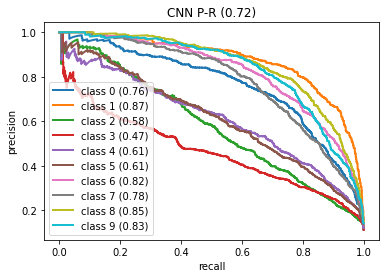

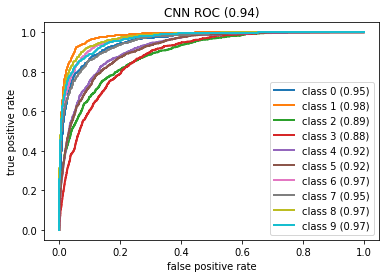

In [37]:
plt.figure()
aucs = dict()
for i in range(10):
    p, r, _ = precision_recall_curve(y_bin_test[:, i], y_zmodelu[:, i])
    plt_auc = auc(r, p)
    aucs[i] = plt_auc
    plt.plot(r, p, lw=2, label='class {0} ({1:0.2f})'.format(i, plt_auc))

plt.legend(loc="best")
plt.xlabel("recall")
plt.ylabel("precision")
avg_auc = np.average(np.array(list(aucs.items()))[:,1])
plt.title("CNN P-R ({0:0.2f})".format(avg_auc))

plt.figure()
aucs = dict()
for i in range(10):
    fpr, tpr, _ = roc_curve(y_bin_test[:, i], y_zmodelu[:, i])
    plt_auc = auc(fpr, tpr)
    aucs[i] = plt_auc
    plt.plot(fpr, tpr, lw=2, label='class {0} ({1:0.2f})'.format(i, plt_auc))

plt.legend(loc="best")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
avg_auc = np.average(np.array(list(aucs.items()))[:,1])
plt.title("CNN ROC ({0:0.2f})".format(avg_auc))

In [38]:
#ocena SVM
print("Dla SVM")
y_pred = clf.predict_proba(intermediate_layer_model.predict(x_test))
print("Accuracy: ")
print(accuracy_score(zamien(y_test), zmaksuj(y_pred)))
print("Loss: ")
print(log_loss(y_test, y_pred))
print("f1-score: ")
print(f1_score(zamien(y_test), zmaksuj(y_pred), average='macro'))

Dla SVM
Accuracy: 
0.7284
Loss: 
0.7919371255095081
f1-score: 
0.7273939985387983


Text(0.5, 1.0, 'SVM ROC (0.96)')

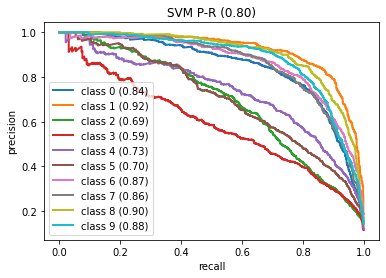

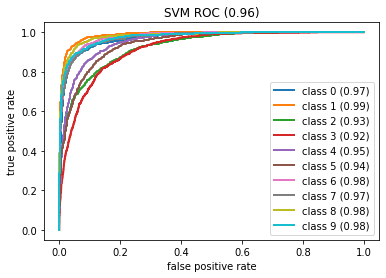

In [40]:
plt.figure()
aucs = dict()
for i in range(10):
    p, r, _ = precision_recall_curve(y_bin_test[:, i], y_pred[:, i])
    plt_auc = auc(r, p)
    aucs[i] = plt_auc
    plt.plot(r, p, lw=2, label='class {0} ({1:0.2f})'.format(i, plt_auc))

plt.legend(loc="best")
plt.xlabel("recall")
plt.ylabel("precision")
avg_auc = np.average(np.array(list(aucs.items()))[:,1])
plt.title("SVM P-R ({0:0.2f})".format(avg_auc))

plt.figure()
aucs = dict()
for i in range(10):
    fpr, tpr, _ = roc_curve(y_bin_test[:, i], y_pred[:, i])
    plt_auc = auc(fpr, tpr)
    aucs[i] = plt_auc
    plt.plot(fpr, tpr, lw=2, label='class {0} ({1:0.2f})'.format(i, plt_auc))

plt.legend(loc="best")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
avg_auc = np.average(np.array(list(aucs.items()))[:,1])
plt.title("SVM ROC ({0:0.2f})".format(avg_auc))

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 187s 4ms/sample - loss: 1.0343 - acc: 0.6306 - val_loss: 0.9472 - val_acc: 0.6631
Epoch 2/30
50000/50000 [==============================] - 191s 4ms/sample - loss: 0.9984 - acc: 0.6476 - val_loss: 0.9103 - val_acc: 0.6814
Epoch 3/30
50000/50000 [==============================] - 191s 4ms/sample - loss: 0.9624 - acc: 0.6571 - val_loss: 0.8781 - val_acc: 0.6917
Epoch 4/30
50000/50000 [==============================] - 190s 4ms/sample - loss: 0.9287 - acc: 0.6707 - val_loss: 0.8785 - val_acc: 0.6927
Epoch 5/30
50000/50000 [==============================] - 191s 4ms/sample - loss: 0.9008 - acc: 0.6809 - val_loss: 0.8524 - val_acc: 0.6980
Epoch 6/30
50000/50000 [==============================] - 191s 4ms/sample - loss: 0.8698 - acc: 0.6917 - val_loss: 0.8052 - val_acc: 0.7159
Epoch 7/30
50000/50000 [==============================] - 189s 4ms/sample - loss: 0.8428 - acc: 0.7010 - val_l

/home/tomasz/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wyniki po 40
Dla CNN
Test accuracy: 0.8033
Loss: 
0.574329615117763
f1-score: 
0.8029202527479942
Dla SVM
Accuracy: 
0.8195
Loss: 
0.5426790338893809
f1-score: 
0.8188779466383668
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 181s 4ms/sample - loss: 0.5229 - acc: 0.8161 - val_loss: 0.5892 - val_acc: 0.7999
Epoch 2/30
50000/50000 [==============================] - 192s 4ms/sample - loss: 0.5188 - acc: 0.8175 - val_loss: 0.5898 - val_acc: 0.7969
Epoch 3/30
50000/50000 [==============================] - 184s 4ms/sample - loss: 0.5061 - acc: 0.8213 - val_loss: 0.5645 - val_acc: 0.8094
Epoch 4/30
50000/50000 [==============================] - 182s 4ms/sample - loss: 0.5038 - acc: 0.8219 - val_loss: 0.5643 - val_acc: 0.8068
Epoch 5/30
50000/50000 [==============================] - 180s 4ms/sample - loss: 0.4950 - acc: 0.8248 - val_loss: 0.5615 - val_acc: 0.8102
Epoch 6/30
50000/50000 [==============================] - 182s 4ms/sam

/home/tomasz/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wyniki po 70
Dla CNN
Test accuracy: 0.8282
Loss: 
0.5346681773728775
f1-score: 
0.8272107071935064
Dla SVM
Accuracy: 
0.8361
Loss: 
0.5104271339195163
f1-score: 
0.8356929937195245
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 186s 4ms/sample - loss: 0.3339 - acc: 0.8816 - val_loss: 0.5513 - val_acc: 0.8246
Epoch 2/30
50000/50000 [==============================] - 190s 4ms/sample - loss: 0.3355 - acc: 0.8782 - val_loss: 0.5511 - val_acc: 0.8242
Epoch 3/30
50000/50000 [==============================] - 188s 4ms/sample - loss: 0.3244 - acc: 0.8839 - val_loss: 0.5397 - val_acc: 0.8274
Epoch 4/30
50000/50000 [==============================] - 189s 4ms/sample - loss: 0.3250 - acc: 0.8823 - val_loss: 0.5487 - val_acc: 0.8287
Epoch 5/30
50000/50000 [==============================] - 189s 4ms/sample - loss: 0.3163 - acc: 0.8871 - val_loss: 0.5481 - val_acc: 0.8275
Epoch 6/30
50000/50000 [==============================] - 189s 4ms/sa

/home/tomasz/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wyniki po 100
Dla CNN
Test accuracy: 0.8333
Loss: 
0.5787450966882335
f1-score: 
0.8331092309277354
Dla SVM
Accuracy: 
0.8386
Loss: 
0.5121846610706818
f1-score: 
0.8381806904404379


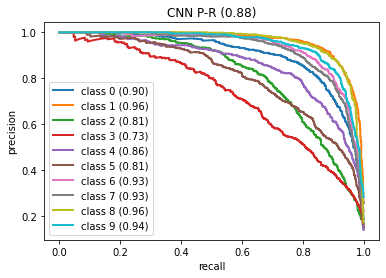

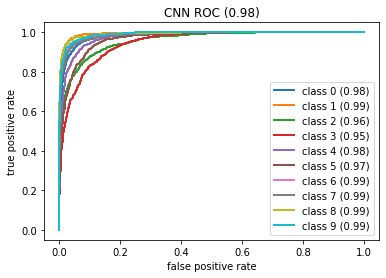

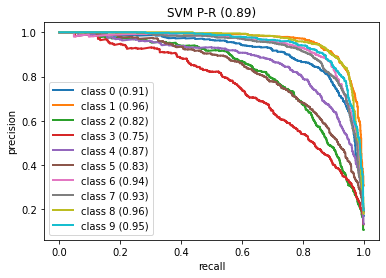

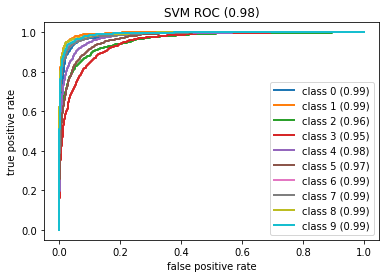

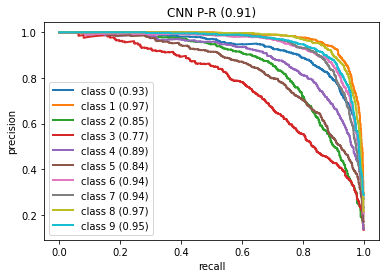

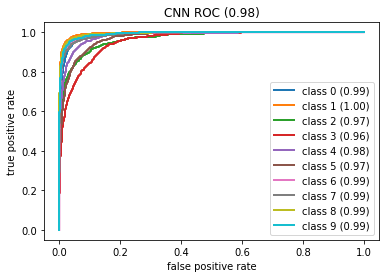

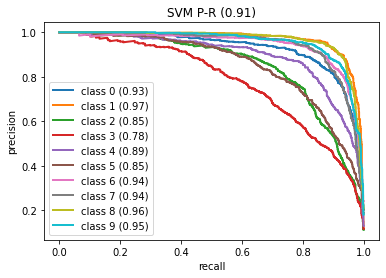

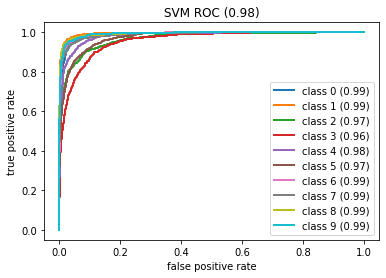

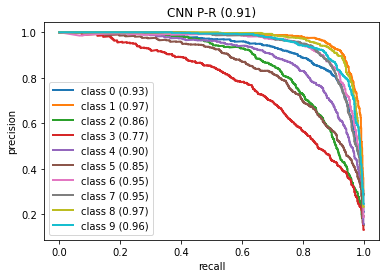

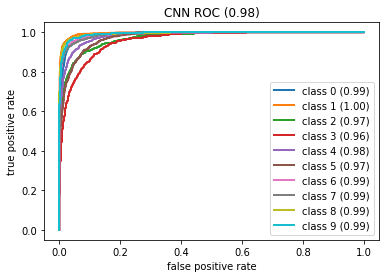

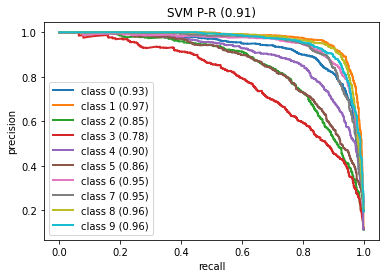

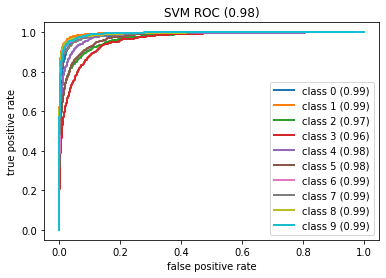

In [41]:
# RESZTA !!!
#TEST !!!
epoki = [30, 30, 30]
epoki_h = [40, 70, 100]

for IT in range(len(epoki)):
    #trening CNN
    history = model.fit(x_train, y_train_cat, epochs=epoki[IT], batch_size=64, validation_data=(x_test, y_test_cat))
    
    #model wyciagajacy wektory przed MLP
    layer_name = "flatten"
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

    #wektory przed MLP
    intermediate_output = intermediate_layer_model.predict(x_train)
    
    #trening SVM
    clf = svm.SVC(probability=True)
    clf.fit(intermediate_output, y_train)
    
    print("Wyniki po "+str(epoki_h[IT]))
    
    #ocena CNN
    print("Dla CNN")
    score = model.evaluate(x_test, y_test_cat, verbose=0)
    #print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    y_zmodelu = model.predict(x_test)
    print("Loss: ")
    print(log_loss(y_test, y_zmodelu))
    print("f1-score: ")
    print(f1_score(zamien(y_test), zmaksuj(y_zmodelu), average='macro'))
    
    plt.figure()
    aucs = dict()
    for i in range(10):
        p, r, _ = precision_recall_curve(y_bin_test[:, i], y_zmodelu[:, i])
        plt_auc = auc(r, p)
        aucs[i] = plt_auc
        plt.plot(r, p, lw=2, label='class {0} ({1:0.2f})'.format(i, plt_auc))
    
    plt.legend(loc="best")
    plt.xlabel("recall")
    plt.ylabel("precision")
    avg_auc = np.average(np.array(list(aucs.items()))[:,1])
    plt.title("CNN P-R ({0:0.2f})".format(avg_auc))
    
    plt.figure()
    aucs = dict()
    for i in range(10):
        fpr, tpr, _ = roc_curve(y_bin_test[:, i], y_zmodelu[:, i])
        plt_auc = auc(fpr, tpr)
        aucs[i] = plt_auc
        plt.plot(fpr, tpr, lw=2, label='class {0} ({1:0.2f})'.format(i, plt_auc))

    plt.legend(loc="best")
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    avg_auc = np.average(np.array(list(aucs.items()))[:,1])
    plt.title("CNN ROC ({0:0.2f})".format(avg_auc))
    
    #ocena SVM
    print("Dla SVM")
    y_pred = clf.predict_proba(intermediate_layer_model.predict(x_test))
    print("Accuracy: ")
    print(accuracy_score(zamien(y_test), zmaksuj(y_pred)))
    print("Loss: ")
    print(log_loss(y_test, y_pred))
    print("f1-score: ")
    print(f1_score(zamien(y_test), zmaksuj(y_pred), average='macro'))
    
    plt.figure()
    aucs = dict()
    for i in range(10):
        p, r, _ = precision_recall_curve(y_bin_test[:, i], y_pred[:, i])
        plt_auc = auc(r, p)
        aucs[i] = plt_auc
        plt.plot(r, p, lw=2, label='class {0} ({1:0.2f})'.format(i, plt_auc))

    plt.legend(loc="best")
    plt.xlabel("recall")
    plt.ylabel("precision")
    avg_auc = np.average(np.array(list(aucs.items()))[:,1])
    plt.title("SVM P-R ({0:0.2f})".format(avg_auc))
    
    plt.figure()
    aucs = dict()
    for i in range(10):
        fpr, tpr, _ = roc_curve(y_bin_test[:, i], y_pred[:, i])
        plt_auc = auc(fpr, tpr)
        aucs[i] = plt_auc
        plt.plot(fpr, tpr, lw=2, label='class {0} ({1:0.2f})'.format(i, plt_auc))

    plt.legend(loc="best")
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    avg_auc = np.average(np.array(list(aucs.items()))[:,1])
    plt.title("SVM ROC ({0:0.2f})".format(avg_auc))